**Importing necessary libraries**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

### Duration Analysis

In [18]:
def macaulay_duration(cash_flows, present_values):
    """
    Calculate the Macaulay duration of a series of cash flows.
    
    Args:
    cash_flows (array-like): Array of cash flows.
    present_values (array-like): Array of present values corresponding to cash flows.
    
    Returns:
    float: Macaulay duration.
    """
    numerator = np.sum([t * cf for t, cf in enumerate(cash_flows, start=1)])
    denominator = np.sum(present_values)
    duration = numerator / denominator
    return duration

def modified_duration(macaulay_duration, yield_to_maturity, coupon_frequency):
    """
    Calculate the modified duration.
    
    Args:
    macaulay_duration (float): Macaulay duration.
    yield_to_maturity (float): Yield to maturity.
    coupon_frequency (int): Number of coupon payments per year.
    
    Returns:
    float: Modified duration.
    """
    modified_duration = macaulay_duration / (1 + (yield_to_maturity / coupon_frequency))
    return modified_duration

def key_rate_duration(cash_flows, present_values, yield_changes):
    """
    Calculate the key rate duration for a given set of yield changes.
    
    Args:
    cash_flows (array-like): Array of cash flows.
    present_values (array-like): Array of present values corresponding to cash flows.
    yield_changes (array-like): Array of yield changes (in decimal form) for each key rate.
    
    Returns:
    array: Array of key rate durations.
    """
    key_rate_durations = []
    for yield_change in yield_changes:
        new_present_values = [pv / (1 + yield_change) for pv in present_values]
        new_macaulay_duration = macaulay_duration(cash_flows, new_present_values)
        key_rate_durations.append(new_macaulay_duration)
    return key_rate_durations

# Example usage:
cash_flows = [100, 100, 100, 100, 1000]  # Example cash flows
present_values = [cf / (1 + 0.05)**(t+1) for t, cf in enumerate(cash_flows)]  # Calculate present values
yield_to_maturity = 0.05  # Example yield to maturity
coupon_frequency = 1  # Example coupon frequency
yield_changes = [0.01, -0.01]  # Example yield changes for key rates

# Calculate Macaulay duration
macaulay_dur = macaulay_duration(cash_flows, present_values)
print("Macaulay Duration:", macaulay_dur)

# Calculate Modified duration
mod_dur = modified_duration(macaulay_dur, yield_to_maturity, coupon_frequency)
print("Modified Duration:", mod_dur)

# Calculate Key rate duration
key_rate_dur = key_rate_duration(cash_flows, present_values, yield_changes)
print("Key Rate Durations:", key_rate_dur)

Macaulay Duration: 5.271846189128615
Modified Duration: 5.020805894408205
Key Rate Durations: [5.324564651019901, 5.219127727237329]


## Vasicek Model

Using Monte-Carlo we simulate different interest rate paths possible using the Vasicek model. We then calculate the Macaulay duration and modified duration for each path:

In [19]:
def vasicek_model(n_simulations, n_steps, r0, mu, kappa, sigma, dt):
    """
    Simulate interest rate paths using the Vasicek model.
    
    Args:
    n_simulations (int): Number of simulation paths.
    n_steps (int): Number of time steps.
    r0 (float): Initial interest rate.
    mu (float): Long-term mean interest rate.
    kappa (float): Speed of mean reversion.
    sigma (float): Volatility.
    dt (float): Time step size.
    
    Returns:
    array: Array of simulated interest rate paths.
    """
    # Initialize array to store simulated paths
    paths = np.zeros((n_simulations, n_steps))
    paths[:, 0] = r0
    
    # Generate interest rate paths
    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), size=n_simulations)
        paths[:, i] = paths[:, i-1] + kappa * (mu - paths[:, i-1]) * dt + sigma * dW
        
    return paths

**Simulation:**

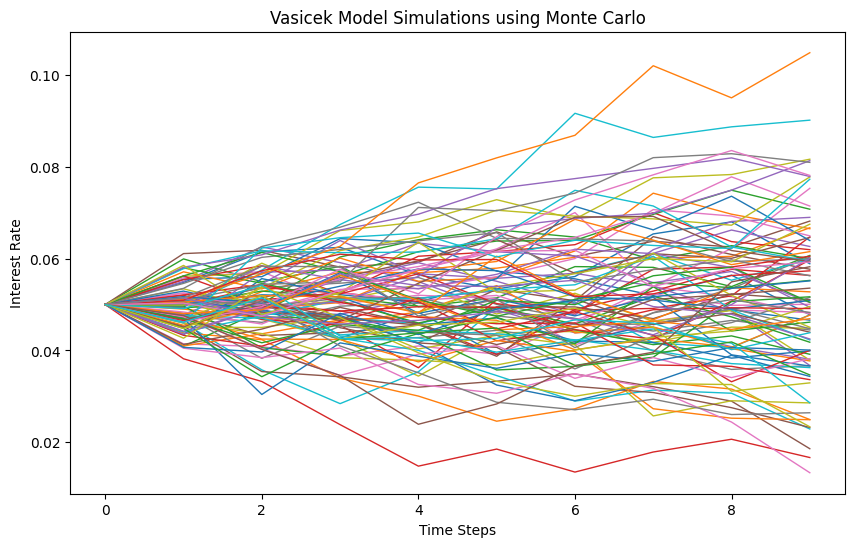

In [20]:
# Parameters
n_simulations = 100  # Number of simulation paths
n_steps = 10  # Number of time steps
r0 = 0.05  # Initial interest rate
mu = 0.04  # Long-term mean interest rate
kappa = 0.1  # Speed of mean reversion
sigma = 0.1  # Volatility
dt = 1/365  # Time step size (1 day)

# Simulate interest rate paths
interest_rate_paths = vasicek_model(n_simulations, n_steps, r0, mu, kappa, sigma, dt)

# Plot interest rate paths
plt.figure(figsize=(10, 6))
plt.plot(interest_rate_paths.T, lw=1)
plt.title('Vasicek Model Simulations using Monte Carlo')
plt.xlabel('Time Steps')
plt.ylabel('Interest Rate')
plt.show()

We then plot the Macaulay duration and modified duration for each path

In [21]:
#ploting the Macaulay duration
# Parameters
yield_to_maturity = 0.05  # Example yield to maturity
dt = 1/365  # Time step size (1 day)

# Calculate duration for each interest rate path
macaulay_durations = []
modified_durations = []

for path in interest_rate_paths:
    cash_flows = np.zeros_like(path)
    present_values = np.zeros_like(path)
    for i, r in enumerate(path):
        cash_flows[i] = 100
        present_values[i] = cash_flows[i] / (1 + r)**(i+1)

    macaulay_durations.append(macaulay_duration(cash_flows, present_values))
    modified_durations.append(modified_duration(macaulay_durations[-1], yield_to_maturity, 1))

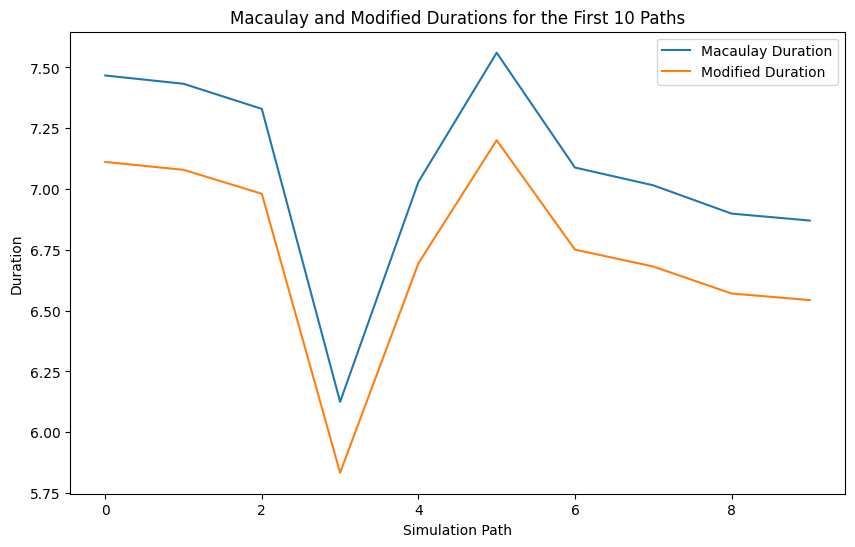

In [23]:
# Plotting 10 first durations
plt.figure(figsize=(10, 6))
plt.plot(macaulay_durations[:10], label='Macaulay Duration')
plt.plot(modified_durations[:10], label='Modified Duration')
plt.title('Macaulay and Modified Durations for the First 10 Paths')
plt.xlabel('Simulation Path')
plt.ylabel('Duration')
plt.legend()
plt.show()

## VaR (Value at Risk)

### Historical VaR

We calculate the historical VaR for the SPX Index using the historical returns of the index.

In [30]:
# Download historical data for SPX index from Yahoo Finance
spx_data = yf.download('^GSPC', start='2021-01-01', end='2022-01-01')

# Calculate daily returns
spx_data['Return'] = spx_data['Adj Close'].pct_change()

# Remove NaN values
spx_returns = spx_data['Return'].dropna()

[*********************100%%**********************]  1 of 1 completed


Plotting the distribution of the returns

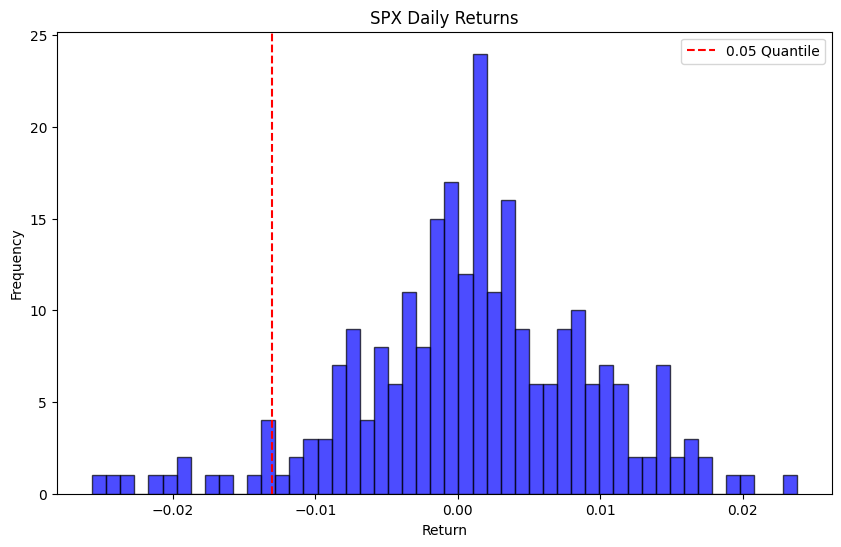

In [35]:
# Plot histogram of returns and percentiles 
plt.figure(figsize=(10, 6))
plt.hist(spx_returns, bins=50, alpha=0.7, color='b', edgecolor='k')
q = 0.05
plt.axvline(spx_returns.quantile(q), linestyle='--', color='r', label=f'{q} Quantile')
plt.legend()
plt.title('SPX Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

In [36]:
# Calculate Historical VaR
confidence_level = 0.95  # Confidence level (e.g., 95%)
historical_var = np.percentile(spx_returns, 100 - confidence_level * 100)

print(f'Historical VaR (95% confidence level) for SPX Index between 2021 and 2022: {historical_var:.2%}')

Historical VaR (95% confidence level) for SPX Index between 2021 and 2022: -1.30%


## Maximum Drawdown

We calculate the maximum drawdown for the SPX Index using the historical returns of the index.

In [50]:
# Calculate the cumulative returns
spx_data['Cumulative Return'] = (1 + spx_data['Return']).cumprod()

# Calculate the running maximum
spx_data['Running Max'] = spx_data['Cumulative Return'].cummax()

# Calculate the running drawdown
spx_data['Drawdown'] = (spx_data['Cumulative Return'] / spx_data['Running Max']) - 1

Text(0, 0.5, 'Running Drawdown')

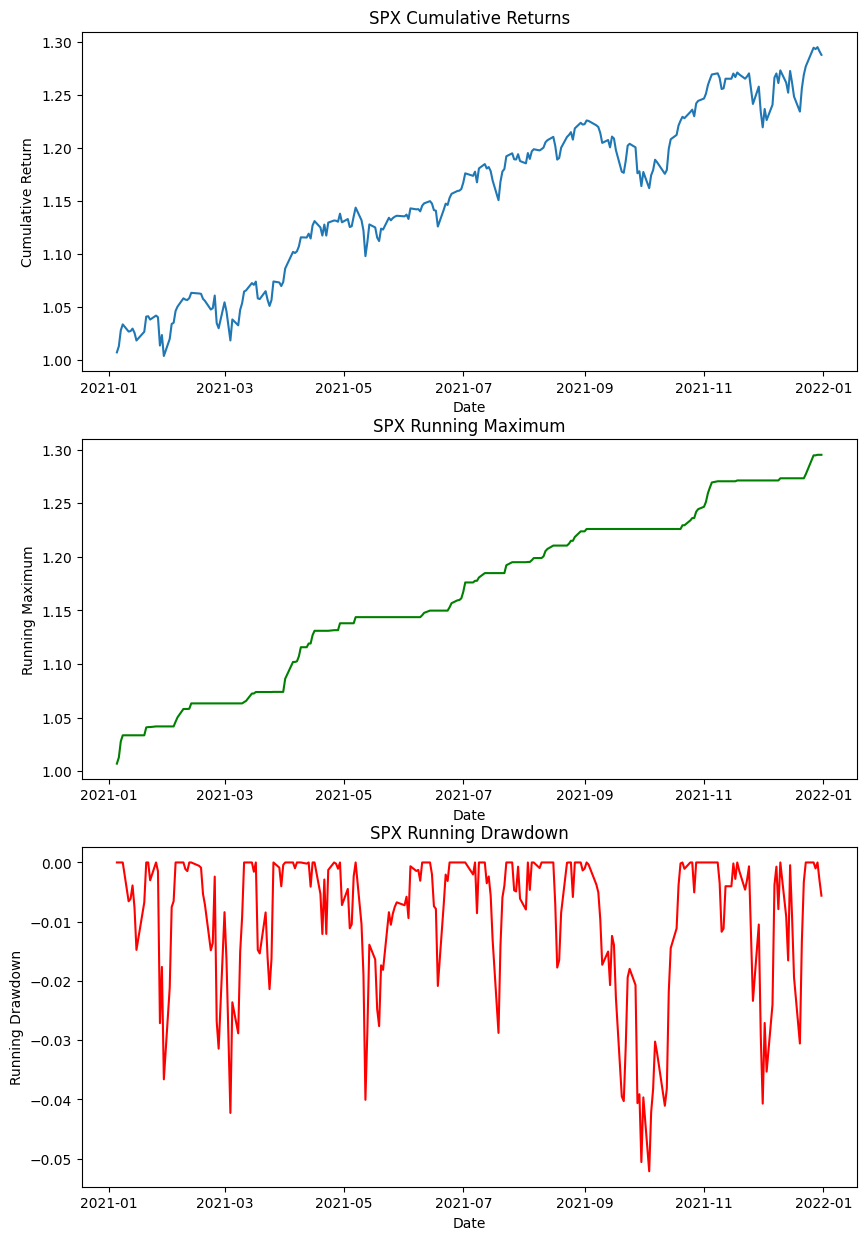

In [51]:
# Plot the cumulative returns, running maximum, and running drawdown
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.plot(spx_data['Cumulative Return'])
plt.title('SPX Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

plt.subplot(3, 1, 2)
plt.plot(spx_data['Running Max'], color='green')
plt.title('SPX Running Maximum')
plt.xlabel('Date')
plt.ylabel('Running Maximum')

plt.subplot(3, 1, 3)
plt.plot(spx_data['Drawdown'], color='red')
plt.title('SPX Running Drawdown')
plt.xlabel('Date')
plt.ylabel('Running Drawdown')

In [53]:
# Calculate the maximum drawdown
max_drawdown = spx_data['Drawdown'].min()


print(f'Maximum Drawdown for SPX Index between 2021 and 2022: {max_drawdown:.2%}')

Maximum Drawdown for SPX Index between 2021 and 2022: -5.21%
